In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import stats

# Movies preprocess

In [42]:
movies_column_names = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date','Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
movies = pd.read_csv('MovieSummaries\movie.metadata.tsv', sep='\t', header=None,names=movies_column_names, decimal='.' )
movies.Movie_release_date = pd.to_datetime(movies.Movie_release_date,format='mixed', errors='coerce', utc=True)

# Language and country

### preprocess language and country

A first step would be to see how much language and country per movies do we have, can we have only one language per movies ?

In [43]:
# Define the functions
def nb_items(vardict):
    # Extract ids and count them to get the number of items
    id = [id for id, name in eval(vardict).items()]
    return len(id)

def list_name(vardict):
    # Extract names
    name = [name.replace("Language", "language").replace("language", "") for id, name in eval(vardict).items()]
    return name if name else None

# Calculate the number of languages and countries for each movie
movies["nb_languages"] = movies['Movie_languages'].apply(nb_items)
movies["nb_country"] = movies['Movie_countries'].apply(nb_items)
movies["nb_genre"] = movies['Movie_genres'].apply(nb_items)

# Extract the list of languages and countries directly
movies["Movie_language"] = movies['Movie_languages'].apply(list_name)
movies["Movie_countries"] = movies['Movie_countries'].apply(list_name)
movies["Movie_genres"] = movies['Movie_genres'].apply(list_name)


In [44]:
movies["nb_languages"].describe()

count    81741.000000
mean         0.994678
std          0.690623
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: nb_languages, dtype: float64

In [45]:
movies["nb_country"].describe()

count    81741.000000
mean         1.057474
std          0.623572
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: nb_country, dtype: float64

Text(0.5, 0, 'Number of countries or languages')

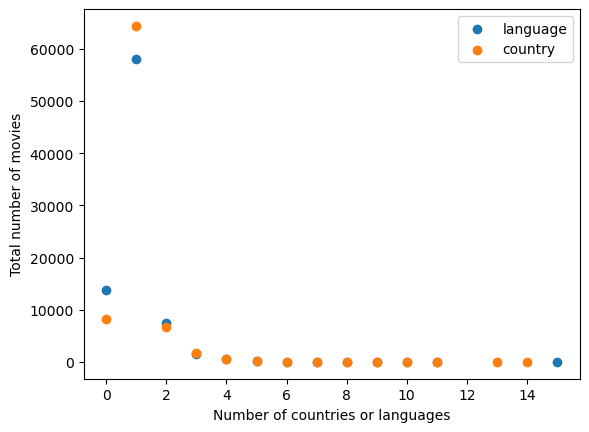

In [46]:
# If we focus on the occurence of each number of language and movies 
total_languages = movies.groupby("nb_languages")["nb_languages"].agg("count")
total_country = movies.groupby("nb_country")["nb_languages"].agg("count")

plt.figure()
plt.scatter(total_languages.index,total_languages.values, label = "language" )
plt.scatter(total_country.index,total_country, label = "country" )
plt.legend()
plt.ylabel("Total number of movies")
plt.xlabel("Number of countries or languages")

From the description and the plot of the total number of movies per number of languages and countries, it appears that the two variables have similar distributions in terms of total counts. However, do they have a similar distribution at the individual movie level? In other words, does a movie associated with 3 countries typically also have 3 languages? 

In [47]:
# statistical study
stats.spearmanr(movies["nb_languages"], movies["nb_country"])

SignificanceResult(statistic=0.37307077954108103, pvalue=0.0)

The two variables seems to be moderatly to low correlated with a high confidence as it is seen with the p-value, thus there is a tendensy of increase of language per movies with the increase of number of countries but the correlation is not that strong

Now that we have studied this, how should we handle outliers? To address this, we can keep only the movies where the number of countries and the number of languages fall between the 5th and 95th percentiles

In [48]:

quantile_5 = np.quantile(movies.nb_languages, 0.05)
quantile_95 = np.quantile(movies.nb_languages, 0.95)

print(f"For language we will keep movies have a number of languages between the 5% percentiles {quantile_5} languages and the 95% percentiles {quantile_95} languages")

For language we will keep movies have a number of languages between the 5% percentiles 0.0 languages and the 95% percentiles 2.0 languages


In [49]:

quantile_5 = np.quantile(movies.nb_country, 0.05)
quantile_95 = np.quantile(movies.nb_country, 0.95)
print(f"For country we will keep movies have a number of countries between the 5% percentiles {quantile_5} countries and the 95% percentiles {quantile_95} countries")

For country we will keep movies have a number of countries between the 5% percentiles 0.0 countries and the 95% percentiles 2.0 countries


### Movies with more than 2 languages 

Lets focus a bit more on the movies out of the range 95 quantile, do they have something in common

In [50]:
movies_language_high = movies.loc[movies.nb_languages>2]
print(f"There is {len(movies_language_high)} with more than 2 languages")

There is 2319 with more than 2 languages


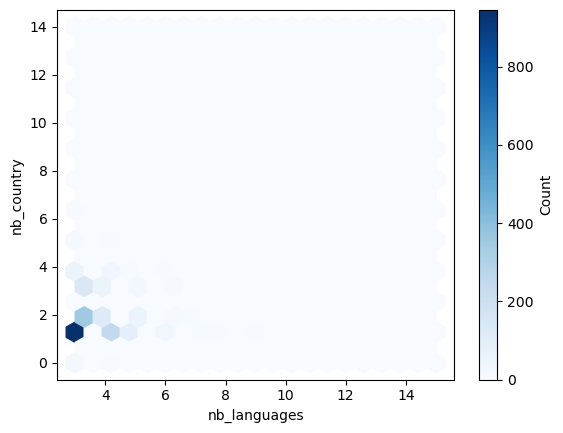

In [51]:


movies_language_high[["nb_languages","nb_country"]]

plt.hexbin(movies_language_high.nb_languages, movies_language_high.nb_country, gridsize=20, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('nb_languages')
plt.ylabel('nb_country')
plt.show()

In [52]:
movies_language_high.groupby("nb_country")["nb_country"].agg("count")

nb_country
0       29
1     1336
2      555
3      241
4      104
5       28
6       13
7        8
8        2
9        2
14       1
Name: nb_country, dtype: int64

We notice here that the majority of movies with more than 2 languages have actually 1 or 2 countries, we can than associate to these movies the language associated to the country they belong to.
To do this, we need to have for each country one main language, we will get this from the movies with 1 country and 1 language

In [53]:
country_language_all = movies.loc[(movies.nb_languages == 1) & (movies.nb_country == 1)].copy()
country_language_all["Movie_language"] = country_language_all["Movie_language"].apply(lambda x: x[0])
country_language_all["Movie_countries"] = country_language_all["Movie_countries"].apply(lambda x: x[0])
country_language_all = country_language_all.groupby(["Movie_language","Movie_countries"])["Movie_name"].agg("count").sort_values(ascending = False).reset_index()


In [54]:
# we keep the couple (language, movie) with the highest occurence
country_language_unique = country_language_all.drop_duplicates(subset=['Movie_countries'], keep='first')
country_language_unique = country_language_unique.reset_index(drop=True)

print(country_language_unique)

    Movie_language           Movie_countries  Movie_name
0         English   United States of America       23431
1         English             United Kingdom        4079
2           Hindi                      India        2865
3        Japanese                      Japan        1684
4         Italian                      Italy        1392
..             ...                       ...         ...
114        Arabic                      Libya           1
115    Macedonian      Republic of Macedonia           1
116     Malayalam                 Malayalam            1
117     Mongolian                   Mongolia           1
118       Italian                     Cyprus           1

[119 rows x 3 columns]


Now that we have this link, we can assign one or two main languages to a movie based on its country. If the movie has a language that appears in the list of languages associated with a country, and the list contains more than two languages, and the movie is associated with one or two countries, we can extract those languages as the main language. We will apply this logic to famous movies that feature multiple languages.

In [55]:
movies_language_high.loc[movies_language_high['nb_country'] == 1, 'Movie_language']= \
    movies_language_high.loc[movies_language_high['nb_country'] == 1, 'Movie_countries'].copy().apply(
    lambda x: country_language_unique.loc[country_language_unique['Movie_countries'] == x[0],'Movie_language'].values)

movies_language_high.loc[movies_language_high['nb_country'] == 2, 'Movie_language'] = \
    movies_language_high.loc[movies_language_high['nb_country'] == 2, 'Movie_countries'].apply(
        lambda x: country_language_unique.loc[
            (country_language_unique['Movie_countries'] == x[0]) | 
            (country_language_unique['Movie_countries'] == x[1]),
            'Movie_language'
        ].values)

movies_language_high.loc[:, "Movie_language"] = movies_language_high["Movie_language"].apply(lambda x: np.unique(x))


movies_language_high.sort_values(by = ["Movie_box_office_revenue"], ascending = False)[["Movie_name", "nb_languages","Movie_countries","Movie_language"]][:20]

,Movie_name,nb_languages,Movie_countries,Movie_language
22256,Titanic,6,[United States of America],[English ]
21432,The Lion King,4,[United States of America],[English ]
10820,Harry Potter and the Goblet of Fire,3,"[United States of America, United Kingdom]",[English ]
60260,Inception,3,"[United States of America, United Kingdom]",[English ]
33405,Indiana Jones and the Kingdom of the Crystal S...,3,[United States of America],[English ]
14453,Spider-Man 2,3,[United States of America],[English ]
53055,2012,9,[United States of America],[English ]
23863,The Da Vinci Code,4,[United States of America],[English ]
19034,The Incredibles,3,[United States of America],[English ]
64107,Fast Five,3,[United States of America],[English ]


In [56]:
movies.loc[movies.nb_languages>2] = movies_language_high

# lets upddate the nb of languages
movies.loc[movies.nb_languages>2, "nb_languages"] = movies.loc[movies.nb_languages>2, 'Movie_language'].apply(lambda x: len(x))
print(len(movies.loc[movies.nb_languages>2]))

428


using this, we go from 2319 movies with more than 2 languages to 428 movies 

### Movies with more than 2 countries

In [57]:
movies_country_high = movies.loc[movies.nb_country>2]
print(f"There is {len(movies_country_high)} with more than 2 countries")

There is 2500 with more than 2 countries


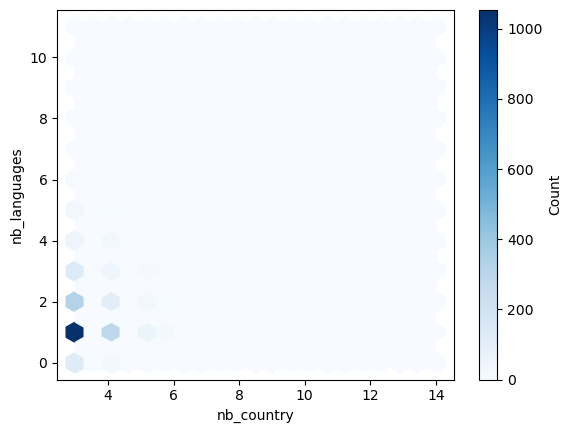

In [58]:


movies_country_high[["nb_languages","nb_country"]]

plt.hexbin(movies_country_high.nb_country,movies_country_high.nb_languages, gridsize=20, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('nb_country')
plt.ylabel('nb_languages')
plt.show()

In [59]:
movies_country_high.groupby("nb_languages")["nb_languages"].agg("count")

nb_languages
0      167
1     1447
2      487
3      217
4      102
5       46
6       23
7        5
8        3
9        1
11       2
Name: nb_languages, dtype: int64

We notice that for movies with multiple countries, the majority have only one or two languages. This suggests that there may be one or two primary countries associated with each movie, while the other countries likely contribute only a few scenes. Based on this observation, we can infer the main countries by focusing on the primary language(s) of the movie

In [60]:
def filter_countries_by_language(row):

    language = row['Movie_language']
    countries = row['Movie_countries']
    
    
    matching_countries = country_language_unique.loc[country_language_unique['Movie_language'].isin(language), 'Movie_countries'].values

    return [country for country in countries if country in matching_countries]


movies_country_high.loc[movies_country_high['nb_languages'] == 1, 'Movie_countries_selected'] = \
    movies_country_high.loc[movies_country_high['nb_languages'] == 1].apply(filter_countries_by_language, axis=1)


C:\Users\inesk\AppData\Local\Temp\ipykernel_47340\3011072137.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_country_high.loc[movies_country_high['nb_languages'] == 1, 'Movie_countries_selected'] = \


<span style="color:blue"> je n'arrive pas à faire ceci si qqun a une idée </span>

### movies with no language  no country

<span style="color:blue"> On pourrait faire pareil pour les films avec 1 country et 0 languages, vous en pensez quoi? </span>

### Extracting language and country

In [61]:
movies = movies.loc[(movies.nb_languages <= 2) & (movies.nb_country <= 2)]
movies.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,nb_languages,nb_country,nb_genre,Movie_language
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24 00:00:00+00:00,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",1,1,7,[English ]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16 00:00:00+00:00,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",1,1,4,[English ]
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01 00:00:00+00:00,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}",[Norway],"[Crime Fiction, Drama]",1,1,2,[Norwegian ]
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01 00:00:00+00:00,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1,1,3,[English ]
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01 00:00:00+00:00,NaN,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama],1,1,1,[German ]


In [62]:
def get_name(list_items):
    if list_items is None: 
        return None, None
    if len(list_items) == 1:
        return list_items[0], None
    elif len(list_items) == 2:
        return list_items[0], list_items[1]
    return None, None

movies[['FirstLanguage_Name', 'SecondLanguage_Name']] = movies['Movie_language'].apply(lambda x: pd.Series(get_name(x)))

In [63]:
movies[['FirstCountry_Name', 'SecondCountry_Name']] = movies['Movie_countries'].apply(lambda x: pd.Series(get_name(x)))

### Now lets plot result 

Let's look at the 20 most frequently used languages in movies. To do this, we will sum the occurrences of each language as both the first and second language in the data. This gives the total number of movies in which each language appears, meaning that some movies may be counted twice if they contain the language as both primary and secondary.

In [64]:
movies_language1 = movies['FirstLanguage_Name'].dropna().value_counts(ascending=False).reset_index()
movies_language1.columns = ['Language', 'Count']
movies_language1 = movies_language1.set_index('Language')
movies_language2 = movies['SecondLanguage_Name'].dropna().value_counts(ascending=False).reset_index()
movies_language2.columns = ['Language', 'Count']
movies_language2 = movies_language2.set_index('Language').reindex(movies_language1.index, fill_value=0)

merged_languages = movies_language1.merge(movies_language2, left_index=True , right_index=True)
merged_languages["total"] = merged_languages["Count_x"] + merged_languages["Count_y"]
merged_languages = merged_languages.sort_values(by=["total"], ascending = False)


Text(0.5, 0, 'Language')

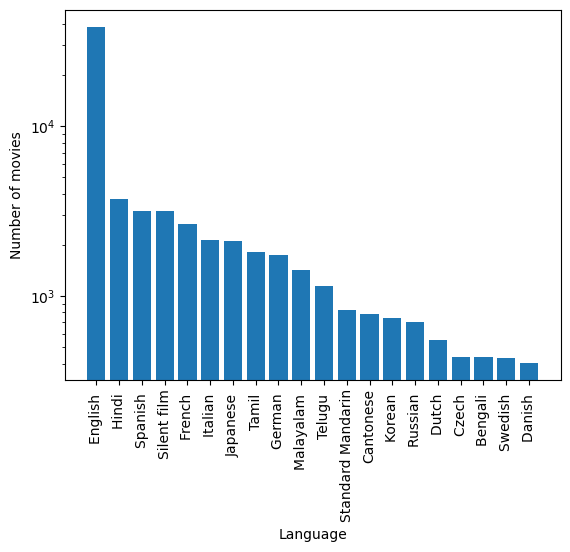

In [65]:

plt.figsize = (15,8)
plt.bar(merged_languages["total"].index[:20],merged_languages["total"][:20])
plt.yscale("log")
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of movies")
plt.xlabel("Language")



Now we will do the same for country

In [66]:
movies_country1 = movies['FirstCountry_Name'].dropna().value_counts(ascending=False).reset_index()
movies_country1.columns = ['country', 'Count']
movies_country1 = movies_country1.set_index('country')
movies_country2 = movies['SecondCountry_Name'].dropna().value_counts(ascending=False).reset_index()
movies_country2.columns = ['country', 'Count']
movies_country2 = movies_country2.set_index('country').reindex(movies_country1.index, fill_value=0)

merged_country = movies_country1.merge(movies_country2, left_index=True , right_index=True)
merged_country["total"] = merged_country["Count_x"] + merged_country["Count_y"]
merged_country = merged_country.sort_values(by=["total"], ascending = False)



Text(0.5, 0, 'Country')

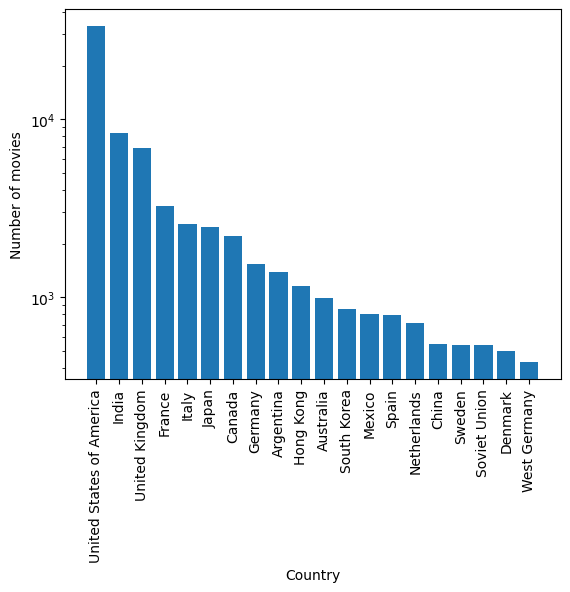

In [67]:
plt.figsize = (15,8)
plt.bar(merged_country["total"].index[:20],merged_country["total"][:20])
plt.yscale("log")
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of movies")
plt.xlabel("Country")



# Genre

Let's focus now on movies genre, lets see how many genre are attributed to each movie

In [68]:
movies["nb_genre"].describe()

count    79212.000000
mean         2.932573
std          2.074385
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         17.000000
Name: nb_genre, dtype: float64

Text(0.5, 0, 'Number of genres')

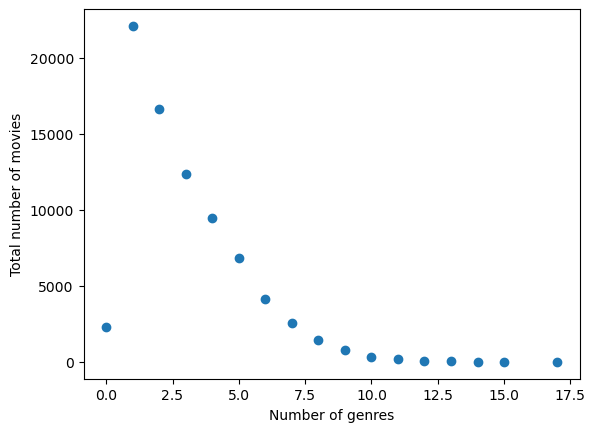

In [69]:
total_genre = movies.groupby("nb_genre")["nb_genre"].agg("count")

plt.figure()
plt.scatter(total_genre.index,total_genre.values)
plt.ylabel("Total number of movies")
plt.xlabel("Number of genres")

Text(0, 0.5, 'Number of genres')

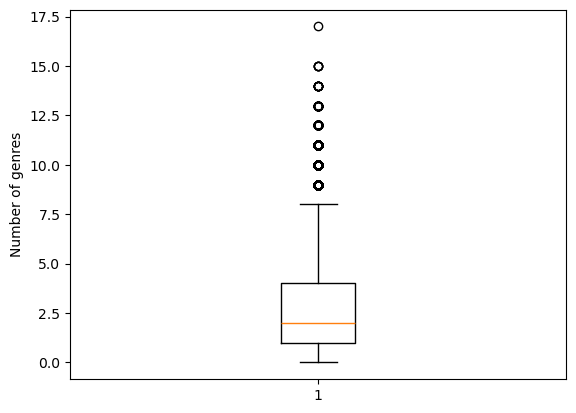

In [70]:
plt.boxplot(movies.nb_genre)
plt.ylabel("Number of genres")

# Runtime

In [71]:
print(movies.Movie_runtime.describe())

# number of Nan in Runtime
print()
print("percentage of Nan in  runtime")
movies.Movie_runtime.isnull().sum()/ len(movies.Movie_runtime)

count    5.884800e+04
mean     1.120563e+02
std      4.449649e+03
min      0.000000e+00
25%      8.000000e+01
50%      9.300000e+01
75%      1.060000e+02
max      1.079281e+06
Name: Movie_runtime, dtype: float64

percentage of Nan in  runtime


0.25708226026359643

In [72]:

quantile_5 = np.quantile(movies.Movie_runtime.dropna(), 0.05)
quantile_95 = np.quantile(movies.Movie_runtime.dropna(), 0.95)
print(f" 5% percentiles {quantile_5} minutes and the 95% percentiles {quantile_95} minutes")

 5% percentiles 20.0 minutes and the 95% percentiles 148.0 minutes


the 95 percentile don't seem that long lets, focus on movies whith the highest runtime

In [73]:
movies.sort_values(by = ['Movie_runtime'], ascending = False).head(10)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,nb_languages,nb_country,nb_genre,Movie_language,FirstLanguage_Name,SecondLanguage_Name,FirstCountry_Name,SecondCountry_Name
12804,10815585,/m/02qqy23,Zero Tolerance,1995-01-01 00:00:00+00:00,NaN,1079281.00,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Crime Fiction, Action, Indie, Actio...",1,1,5,[English ],English,None,United States of America,None
62962,32441022,/m/0gyr803,Modern Times Forever,NaT,NaN,14400.00,{},None,[Documentary],0,0,1,None,None,None,None,None
71100,25345684,/m/09gqhh3,Cinématon,2011-01-01 00:00:00+00:00,NaN,9360.00,"{""/m/064_8sq"": ""French Language""}",[France],"[Experimental film, Documentary]",1,1,2,[French ],French,None,France,None
21733,14545195,/m/03qcghh,Matrjoschka,2006-04-23 00:00:00+00:00,NaN,5700.00,{},[Germany],"[Indie, Documentary]",0,1,2,None,None,None,Germany,None
46666,884435,/m/03lmv2,The Cure for Insomnia,1987-01-31 00:00:00+00:00,NaN,5220.00,"{""/m/02h40lc"": ""English Language""}",[United States of America],[Art film],1,1,1,[English ],English,None,United States of America,None
16316,21689271,/m/05q4cg8,Paradise in Harlem,NaT,NaN,5100.00,{},[United States of America],"[Crime Fiction, Drama]",0,1,2,None,None,None,United States of America,None
27036,36136594,/m/0k0ryr0,Kai Koduttha Dheivam,1964-07-18 00:00:00+00:00,NaN,4875.27,"{""/m/07c9s"": ""Tamil Language""}",[India],None,1,1,0,[Tamil ],Tamil,None,India,None
68223,884492,/m/03lm_0,The Longest Most Meaningless Movie in the World,1968-01-01 00:00:00+00:00,NaN,2880.00,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],[Experimental film],1,1,1,[English ],English,None,United Kingdom,None
73658,1348747,/m/04vq_r,Gigantor,1963-10-20 00:00:00+00:00,NaN,2425.00,"{""/m/02h40lc"": ""English Language""}",[Japan],"[Thriller, Science Fiction, Anime, Action, Ani...",1,1,5,[English ],English,None,Japan,None
73630,6012645,/m/0fkkf0,Dil Ne Phir Yaad Kiya,1966-01-01 00:00:00+00:00,NaN,1966.00,"{""/m/03k50"": ""Hindi Language""}",[India],"[Bollywood, World cinema]",1,1,2,[Hindi ],Hindi,None,India,None


The first one of 17 988 hours is actually an error, as no movies of this length exist in the record ( the longest movie ever is of 857 hours) when searching online.

In [74]:
long_movie = movies.sort_values(by = ['Movie_runtime'], ascending = False).head(1)
movies = movies.drop(long_movie.index, axis = 0)

<span style="color:blue"> Je pense qu on peut approfondir cette analyse  et voir ce qu'on enlève en plus du premier outlier </span>

Now lets focus on the short movies of less then 20 minutes


In [75]:
short_movies = movies.loc[((movies.Movie_runtime <quantile_5))]

# check if short film is in the list of genre
sum = 0
for j in short_movies["Movie_genres"]:
    sum += j.count("Short Film")

if sum == len(short_movies):
    print("All movies bellow 20 minutes have a genre short film")

All movies bellow 20 minutes have a genre short film


(array([ 91., 192., 194., 295., 381., 174., 146.,  91., 202., 664.]),
 array([1888. , 1900.5, 1913. , 1925.5, 1938. , 1950.5, 1963. , 1975.5,
        1988. , 2000.5, 2013. ]),
 <BarContainer object of 10 artists>)

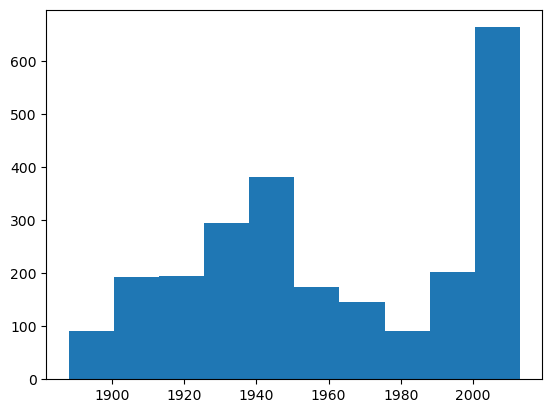

In [76]:
plt.figure()
plt.hist(short_movies.Movie_release_date.dt.year)

<span style="color:blue"> on pourrait voir la proportion de short movie selon les années voir l'évolution de ce genre </span>

In [77]:
movies_time = movies.loc[((movies.Movie_runtime > quantile_5))| (movies.Movie_runtime.isna())]


Now that we took off short and long ones , we get 

# Revenues

In [79]:
print(movies.Movie_box_office_revenue.describe())

# number of Nan in Runtime
print()
print("percentage of Nan")
movies.Movie_box_office_revenue.isnull().sum()/ len(movies.Movie_box_office_revenue)

count    7.806000e+03
mean     4.777198e+07
std      1.134544e+08
min      1.000000e+04
25%      2.023818e+06
50%      1.039685e+07
75%      4.012874e+07
max      2.782275e+09
Name: Movie_box_office_revenue, dtype: float64

percentage of Nan


0.9014530810114757

 # Lets focus on the release year

In [80]:
movies.Movie_release_date.dt.year.describe()

count    72372.000000
mean      1976.874164
std         29.034312
min       1888.000000
25%       1955.000000
50%       1984.000000
75%       2003.000000
max       2016.000000
Name: Movie_release_date, dtype: float64

Text(0.5, 0, 'Year')

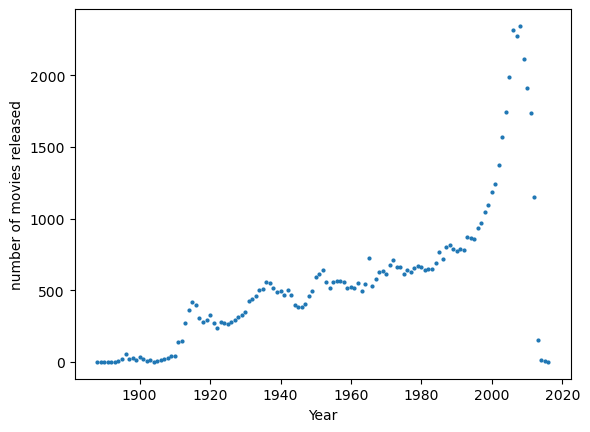

In [81]:
# not cleaned 
yearly_movies = movies.groupby(movies.Movie_release_date.dt.year)['Movie_release_date'].agg('count')
plt.scatter(yearly_movies.index, yearly_movies, s= 4)
plt.ylabel("number of movies released")
plt.xlabel("Year")

Text(0.5, 1.0, 'Movies Language per year')

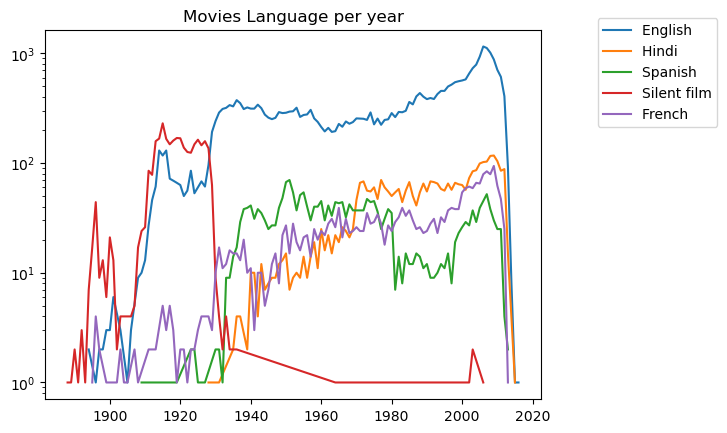

In [82]:

for language in merged_languages.index[:5]:
    movies_language_year = movies.loc[movies.FirstLanguage_Name == language].groupby(movies.Movie_release_date.dt.year)['FirstLanguage_Name'].agg('size')
    plt.plot(movies_language_year, label = language)
    plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Movies Language per year")

Text(0.5, 1.0, 'Movies Language per year')

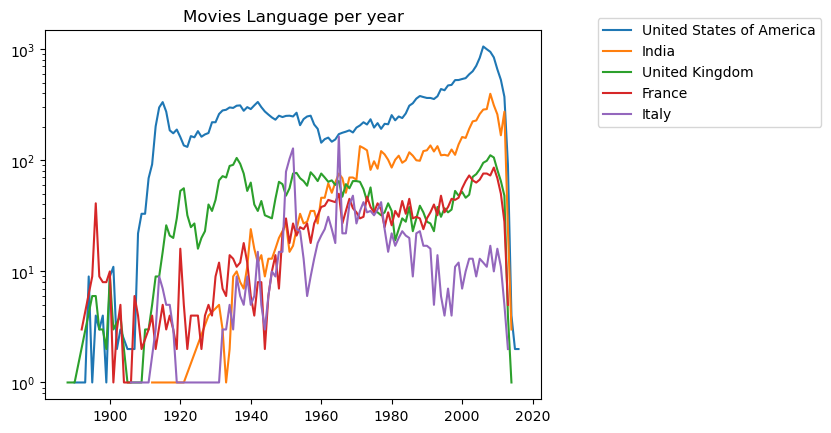

In [83]:
for country in merged_country.index[:5]:
    movies_country_year = movies.loc[movies.FirstCountry_Name == country].groupby(movies.Movie_release_date.dt.year)['FirstCountry_Name'].agg('size')
    plt.plot(movies_country_year, label = country)
    plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Movies Language per year")

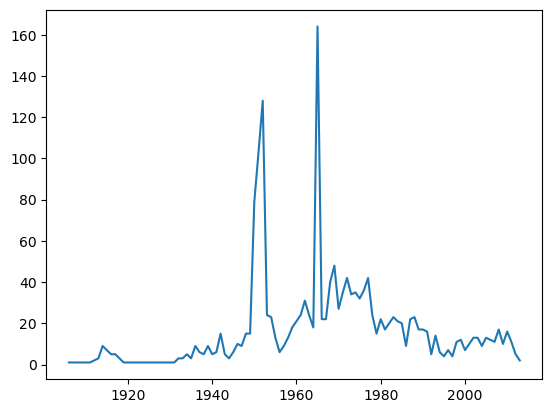

In [84]:
# yearly runtime
movies_runtime_year = movies.dropna(subset = ['Movie_runtime']).groupby(movies.Movie_release_date.dt.year)['Movie_runtime'].agg('mean')
plt.plot(movies_country_year, label = country)

# save 